# Feasible Hypercubemap Generation

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Machine Learning in the Design and Analysis for Steel Connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

In this file, different methods to create feasible hypercubemaps (FHCM) are explored and one method is chosen to create a FHCM given a dataset

**Dependencies**: 
- `CVAE.py`
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`
- `Saved Models\DNN_trained_model\DNN_trained_model.pth`

## Setup

### Import

In [3]:
from DataReader import DataReader
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time

from Settings import Directory, Plotting_Parameters

In [4]:
plot_params = Plotting_Parameters()

### Load Data

In [5]:
datareader = DataReader()
df_full = datareader.load('Knee_Connection_Output_red.csv')
df = df_full.copy()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)


### Define Features

In [4]:
features = ["A_x", "Iy_x", "Wely_x", "Wply_x", "fy_x", 
            "A_y", "Iy_y", "Wely_y", "Wply_y", "fy_y", 
            "Gamma", "Offset",
            "h_wid", "b_wid", "d_wid", "t_fwid", "t_wwid", 
            "t_stiffc", "t_stiffb",
            "Cat_h", "Cat_t_stiffc"] 

### Number of Hypercubes

In [5]:
data_unique_values = []

for feature in features:
    data_unique_values.append(len(df[feature].unique()))

data_unique_values = np.array(data_unique_values)

In [6]:
data_unique_values.mean()

59.666666666666664

In [7]:
m = data_unique_values.mean()             # bins per dimension
N = len(df_full)    # number of samples
D = len(features)   # dimensions

print(f"Number of hypercube: {m**D}")

Number of hypercube: 1.951494364480737e+37


Trying to iterate throgh all hypercubes with:

`hist, edges = np.histogramdd(df[features].values, bins=m)`
`empty_indices = np.argwhere(hist == 0)`

will lead to a memory error:

`MemoryError: Unable to allocate 11.6 PiB for an array with shape (1628413597910449,) and data type int64`

**Compuational Efficiency: Hypercube Iteration**

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><menclose notation="box"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="false"><mstyle scriptlevel="0" displaystyle="true"><mrow><mi>O</mi><mo stretchy="false">(</mo><mi>N</mi><mo>⋅</mo><mi>D</mi><mo>⋅</mo><mi>log</mi><mo>⁡</mo><mi>m</mi><mo stretchy="false">)</mo><mo>+</mo><mi>O</mi><mo stretchy="false">(</mo><msup><mi>m</mi><mi>D</mi></msup><mo stretchy="false">)</mo></mrow></mstyle></mstyle></mstyle></menclose></mrow><annotation encoding="application/x-tex">\boxed{
O(N \cdot D \cdot \log m) + O(m^D)
}</annotation></semantics></math>

- N: Samples
- D: Dimensions (Features)
- m: Bins per dimension

First term: binning the data

Second term: generating + filtering all hypercubes

## Illustrate Empty Space

In [9]:
bins_per_dim = 7

Show empty bins in 1 Dimensions

Bins: 7
Empty bins: 2


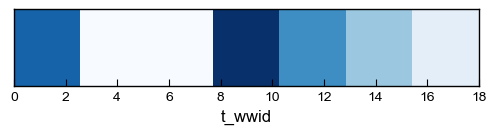

In [10]:
features_1D = "t_wwid"
m = bins_per_dim

counts, bins = np.histogram(df[features_1D], bins=m)

fig, ax = plt.subplots(figsize=(6, 1))
plt.imshow(counts.reshape(1, -1), cmap='Blues', aspect='auto',extent=[bins[0], bins[-1], 0, 1])
plt.xlabel(features_1D)
plt.yticks([])

empty_bins = np.argwhere(counts == 0).flatten()
print(f"Bins: {m}\nEmpty bins: {len(empty_bins)}")


Show empty bins in 2 Dimensions

Bins: 49
Empty bins: 23


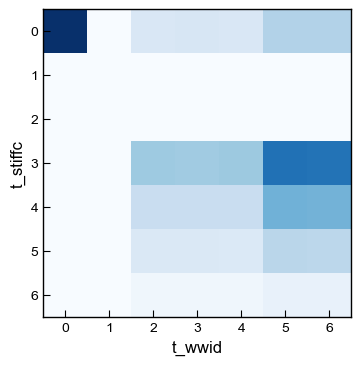

In [11]:
features_2D = ["t_wwid", "t_stiffc"]
m = [bins_per_dim,bins_per_dim]

counts, bins = np.histogramdd(df[features_2D].values, bins=m)

fig, ax = plt.subplots(figsize=(6, 4))
plt.imshow(counts, cmap='Blues')
plt.xlabel(features_2D[0])
plt.ylabel(features_2D[1])

empty_bins = np.argwhere(counts == 0)
print(f"Bins: {m[0]*m[1]}\nEmpty bins: {len(empty_bins)}")

Show empty bins in 3 Dimensions

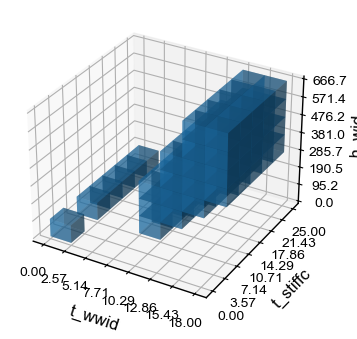

Bins: 343
Empty bins: 257


In [12]:
features_3D = ["t_wwid", "t_stiffc", "h_wid"]

m = [bins_per_dim, bins_per_dim, bins_per_dim]

counts, edges = np.histogramdd(df[features_3D].values, bins=m)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

x_edges, y_edges, z_edges = edges
dx = (x_edges[1] - x_edges[0])
dy = (y_edges[1] - y_edges[0])
dz = (z_edges[1] - z_edges[0])

for i in range(m[0]):
    for j in range(m[1]):
        for k in range(m[2]):
            if counts[i, j, k] > 0:
                x = x_edges[i]
                y = y_edges[j]
                z = z_edges[k]
                ax.bar3d(x, y, z, dx, dy, dz, shade=True, alpha=0.5 ,color=plot_params.colors[0])

ax.set_xlabel(features_3D[0])
ax.set_ylabel(features_3D[1])
ax.set_zlabel(features_3D[2])

ax.set_xticks(x_edges)
ax.set_yticks(y_edges)
ax.set_zticks(z_edges)

#plt.tight_layout()
plt.show()

empty_bins = np.argwhere(counts == 0)
print(f"Bins: {m[0]*m[1]*m[2]}\nEmpty bins: {len(empty_bins)}")

In [13]:
dims = np.arange(1,7)
features_to_test = ["t_wwid", "t_stiffc", "h_wid", "b_wid", "d_wid", "t_fwid"]

total_bins = []
empty_bins = []

for dim in dims:
    m = [10] * dim
    features_in_dim = features_to_test[:dim]
    counts, bins = np.histogramdd(df[features_in_dim].values, bins=m)

    empty = np.argwhere(counts == 0)

    total_bins.append(10**dim)
    empty_bins.append(len(empty))

total_bins = np.array(total_bins)
empty_bins = np.array(empty_bins)

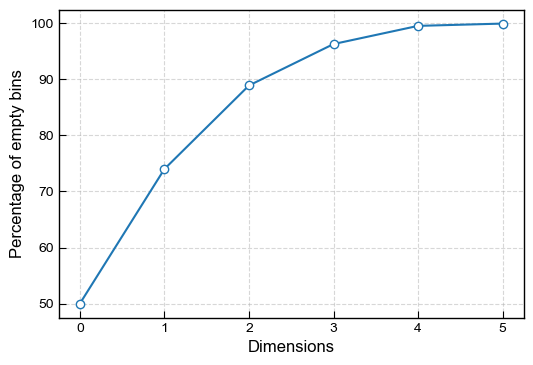

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

empty_ratio = empty_bins/total_bins
plt.plot(empty_ratio*100, 
         c=plot_params.colors[0],
         marker='o', 
         markeredgecolor=plot_params.colors[0],
         markerfacecolor='white',
         label="Empty bins")

plt.xlabel("Dimensions")
plt.ylabel("Percentage of empty bins")

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

For high dimensions (>8) the above calculation takes a long time. To be able to estimate the percentage of empty bins for higher dimensions, I fit a curve to the calculated values to be able to create an analytical expression, which can be used to extrapolate to higher dimensions.

C:\Users\benja\AppData\Local\Temp\ipykernel_1688\2320866733.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(len(empty_ratio)),empty_ratio*100,


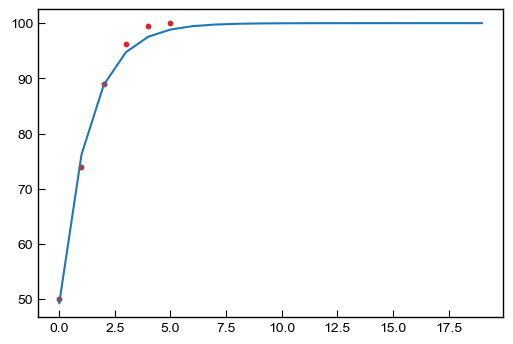

In [15]:
from scipy.optimize import curve_fit

def exp_decay(x, a, b):
    return 1 - a * np.exp(-b * x)

# Fit the exponential decay model to the data
params, covariance = curve_fit(exp_decay, np.arange(len(empty_ratio)), empty_ratio, p0=[0.5, 0.1])
# Get the fitted values
y_fitted = exp_decay(np.arange(20), *params)

plt.scatter(np.arange(len(empty_ratio)),empty_ratio*100, 
         c=plot_params.colors[3],
         s=10
         )
# Plot the results
plt.plot(np.arange(20), y_fitted*100)

In [16]:
print(f"Number of estimated non-empty hypercubes: {exp_decay(20, *params)*len(features)**5:.0f}")

Number of estimated non-empty hypercubes: 4084100


## Compare Complexity of Covering Methods

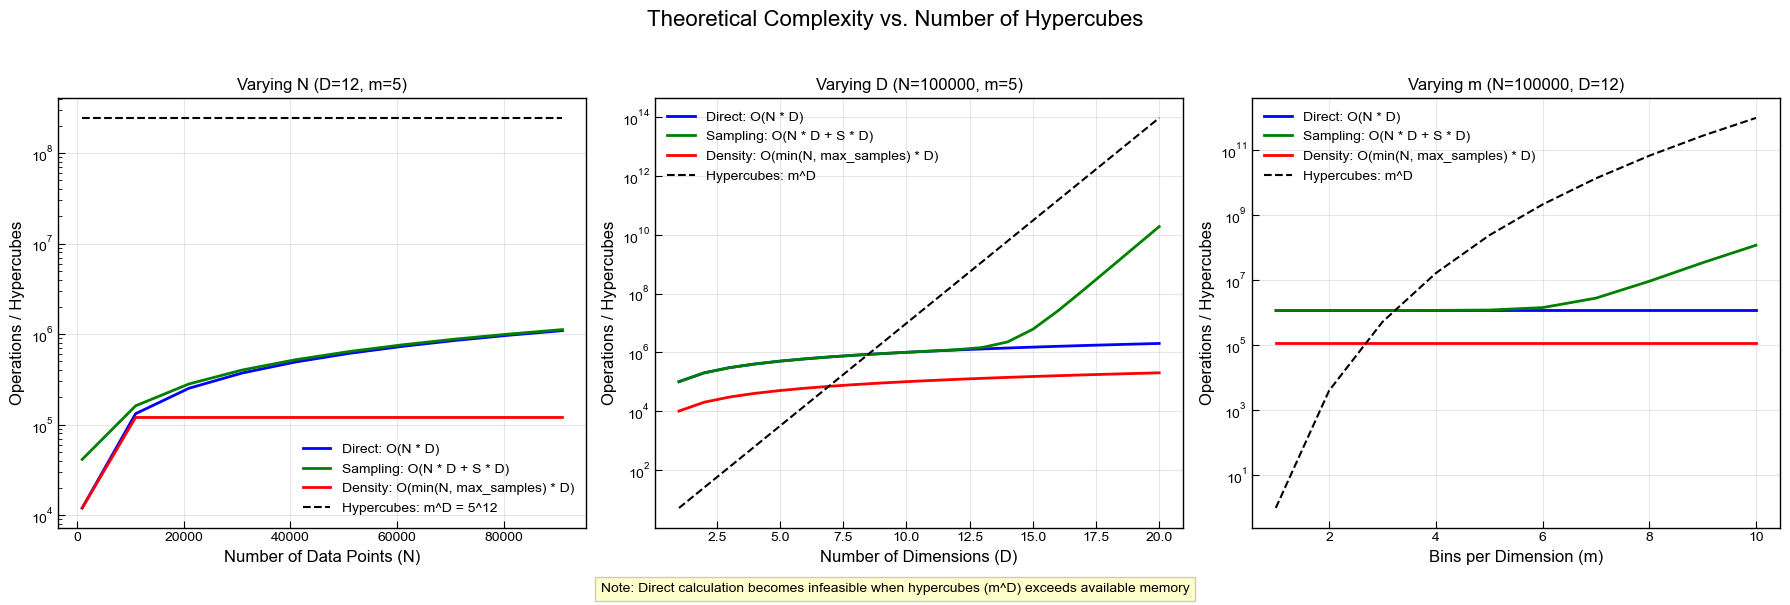

In [40]:
# Define default parameters
N = 100_000  # Number of data points
D = 12      # Dimensions
m = 5      # Bins per dimension
sampling_rate_factor = 100_000  # How many times should be samples per hypercubes
max_samples = 10_000  # For density analysis

# Set up the figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ------ Plot 1: Varying N ------ 
N_values = np.arange(1000, 100_000, 10_000)

# Complexity equations for each method
direct_N = N_values * D  # O(N * D)
density_N = np.minimum(N_values, max_samples) * D  # O(min(N, max_samples) * D)
hypercubes_N = np.ones_like(N_values) * (m ** D)  # Number of hypercubes stays constant
sampling_rate = hypercubes_N / sampling_rate_factor
sampling_N = N_values * D + sampling_rate * D  # O(N * D + sample_size * D)

axs[0].plot(N_values, direct_N, 'b-', linewidth=2, label='Direct: O(N * D)')
axs[0].plot(N_values, sampling_N, 'g-', linewidth=2, label='Sampling: O(N * D + S * D)')
axs[0].plot(N_values, density_N, 'r-', linewidth=2, label='Density: O(min(N, max_samples) * D)')
axs[0].plot(N_values, hypercubes_N, 'k--', linewidth=1.5, label=f'Hypercubes: m^D = {m}^{D}')

axs[0].set_title(f'Varying N (D={D}, m={m})')
axs[0].set_xlabel('Number of Data Points (N)')
axs[0].set_ylabel('Operations / Hypercubes')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# ------ Plot 2: Varying D ------ 
D_values = np.arange(1, 21, 1)

# Complexity equations
direct_D = N * D_values
density_D = np.minimum(N, max_samples) * D_values
hypercubes_D =  np.exp(D_values * np.log(m))  # Number of hypercubes varies with D
sampling_rate = hypercubes_D / sampling_rate_factor
sampling_D = N * D_values + sampling_rate * D_values

axs[1].plot(D_values, direct_D, 'b-', linewidth=2, label='Direct: O(N * D)')
axs[1].plot(D_values, sampling_D, 'g-', linewidth=2, label='Sampling: O(N * D + S * D)')
axs[1].plot(D_values, density_D, 'r-', linewidth=2, label='Density: O(min(N, max_samples) * D)')
axs[1].plot(D_values, hypercubes_D, 'k--', linewidth=1.5, label='Hypercubes: m^D')

axs[1].set_title(f'Varying D (N={N}, m={m})')
axs[1].set_xlabel('Number of Dimensions (D)')
axs[1].set_ylabel('Operations / Hypercubes')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# ------ Plot 3: Varying m ------ 
m_values = np.arange(1, 11, 1)

# Complexity equations
direct_m = np.ones_like(m_values) * N * D  # Constant when varying m
density_m = np.ones_like(m_values) * min(N, max_samples) * D  # Constant when varying m
hypercubes_m = np.exp(D * np.log(m_values))  # Number of hypercubes varies with m
sampling_rate = hypercubes_m / sampling_rate_factor
sampling_m = np.ones_like(m_values) * (N * D + sampling_rate * D)  # Constant when varying m

axs[2].plot(m_values, direct_m, 'b-', linewidth=2, label='Direct: O(N * D)')
axs[2].plot(m_values, sampling_m, 'g-', linewidth=2, label='Sampling: O(N * D + S * D)')
axs[2].plot(m_values, density_m, 'r-', linewidth=2, label='Density: O(min(N, max_samples) * D)')
axs[2].plot(m_values, hypercubes_m, 'k--', linewidth=1.5, label='Hypercubes: m^D')

axs[2].set_title(f'Varying m (N={N}, D={D})')
axs[2].set_xlabel('Bins per Dimension (m)')
axs[2].set_ylabel('Operations / Hypercubes')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

# Add a note about practical feasibility
fig.suptitle('Theoretical Complexity vs. Number of Hypercubes', fontsize=16)
plt.figtext(0.5, 0.01, 'Note: Direct calculation becomes infeasible when hypercubes (m^D) exceeds available memory', 
           ha='center', fontsize=10, bbox=dict(facecolor='yellow', alpha=0.2))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Application of Covering Methods

In [17]:
def count_empty_hypercubes(data, num_bins=5):
    """
    Count empty hypercubes in high-dimensional data.
    
    Parameters:
    - data: numpy array of shape (N, D) where N is number of points and D is dimensionality
    - num_bins: number of bins to divide each dimension into
    
    Returns:
    - number of empty hypercubes
    - total possible hypercubes
    - percentage of empty hypercubes
    """
    start_time = time.time()
    
    N, D = data.shape
    print(f"Processing {N} points in {D} dimensions with {num_bins} bins per dimension")
    
    # Calculate the total number of possible hypercubes
    total_hypercubes = num_bins ** D
    print(f"Total possible hypercubes: {total_hypercubes:,}")
    
    # Find min and max for each dimension to normalize
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    
    # Small epsilon to prevent edge cases
    epsilon = 1e-10
    
    # Create a set to store occupied hypercube indices
    occupied_hypercubes = set()
    
    # Process data in batches to avoid memory issues
    batch_size = 10000
    num_batches = (N + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, N)
        
        batch_data = data[start_idx:end_idx]
        
        # Normalize and bin the data
        normalized_data = (batch_data - min_vals) / (range_vals + epsilon)
        bin_indices = np.floor(normalized_data * num_bins).astype(int)
        
        # Clip to handle edge cases
        bin_indices = np.clip(bin_indices, 0, num_bins - 1)
        
        # Convert each point's hypercube coordinate to a tuple and add to set
        for point_idx in range(bin_indices.shape[0]):
            hypercube_idx = tuple(bin_indices[point_idx])
            occupied_hypercubes.add(hypercube_idx)
    
    # Calculate metrics
    num_occupied = len(occupied_hypercubes)
    num_empty = total_hypercubes - num_occupied
    percentage_empty = (num_empty / total_hypercubes) * 100
    
    end_time = time.time()
    
    print(f"Processing completed in {end_time - start_time:.2f} seconds")
    print(f"Occupied hypercubes: {num_occupied:,}")
    print(f"Empty hypercubes: {num_empty:,}")
    print(f"Percentage empty: {percentage_empty:.10f}%")
    
    return num_empty, total_hypercubes, percentage_empty, occupied_hypercubes

# Memory-efficient approach for estimating empty hypercubes without storing all occupied ones
def estimate_empty_hypercubes(data, num_bins=5, sample_size=1000000):
    """
    Estimate the percentage of empty hypercubes by random sampling.
    Useful when D^m is too large to enumerate all hypercubes.
    
    Parameters:
    - data: numpy array of shape (N, D) where N is number of points and D is dimensionality
    - num_bins: number of bins to divide each dimension into
    - sample_size: number of random hypercubes to sample
    
    Returns:
    - estimated percentage of empty hypercubes
    """
    N, D = data.shape
    print(f"Estimating empty hypercubes with {sample_size:,} samples")
    
    start_time = time.time()
    
    # Find min and max for each dimension
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    epsilon = 1e-10
    
    # Normalize and bin the data
    normalized_data = (data - min_vals) / (range_vals + epsilon)
    bin_indices = np.floor(normalized_data * num_bins).astype(int)
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    
    # Convert to a set of occupied bin tuples for fast lookup
    occupied_bins = set(tuple(bin_indices[i]) for i in range(N))
    
    # Sample random hypercubes and check if they're occupied
    empty_count = 0
    for _ in range(sample_size):
        random_bin = tuple(np.random.randint(0, num_bins, D))
        if random_bin not in occupied_bins:
            empty_count += 1
    
    estimated_empty_percentage = (empty_count / sample_size) * 100
    
    end_time = time.time()
    
    print(f"Estimation completed in {end_time - start_time:.2f} seconds")
    print(f"Estimated percentage of empty hypercubes: {estimated_empty_percentage:.10f}%")
    
    total_hypercubes = num_bins ** D
    estimated_empty = int(total_hypercubes * estimated_empty_percentage / 100)
    print(f"Estimated number of empty hypercubes: {estimated_empty:,} out of {total_hypercubes:,}")
    
    return estimated_empty_percentage

# Density-based approach - faster for very high dimensional cases
def analyze_hypercube_density(data, num_bins=5, max_samples=1000000):
    """
    Analyzes the density and distribution of data points in hypercube space.
    This is useful when D^m is extremely large.
    
    Parameters:
    - data: numpy array of shape (N, D)
    - num_bins: number of bins per dimension
    - max_samples: maximum number of points to process (for performance)
    
    Returns:
    - density statistics
    """
    N, D = data.shape
    print(f"Analyzing hypercube density with {min(N, max_samples):,} points")
    
    # Subsample if necessary
    if N > max_samples:
        indices = np.random.choice(N, max_samples, replace=False)
        data_sample = data[indices]
    else:
        data_sample = data
    
    # Find min and max for each dimension
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    epsilon = 1e-10
    
    # Normalize and bin the data
    normalized_data = (data_sample - min_vals) / (range_vals + epsilon)
    bin_indices = np.floor(normalized_data * num_bins).astype(int)
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    
    # Count points per hypercube
    hypercube_counts = Counter(tuple(bin_indices[i]) for i in range(len(data_sample)))
    
    # Calculate statistics
    num_occupied = len(hypercube_counts)
    max_density = max(hypercube_counts.values())
    avg_density = len(data_sample) / num_occupied if num_occupied > 0 else 0
    
    total_hypercubes = num_bins ** D
    occupancy_rate = num_occupied / total_hypercubes * 100
    
    print(f"Number of occupied hypercubes: {num_occupied:,} out of {total_hypercubes:,}")
    print(f"Occupancy rate: {occupancy_rate:.8f}%")
    print(f"Average points per occupied hypercube: {avg_density:.2f}")
    print(f"Maximum points in any hypercube: {max_density}")
    
    # Estimate empty hypercubes
    empty_hypercubes = total_hypercubes - num_occupied
    empty_percentage = 100 - occupancy_rate
    
    print(f"Estimated empty hypercubes: {empty_hypercubes:,}")
    print(f"Estimated empty percentage: {empty_percentage:.10f}%")
    
    return {
        "occupied_hypercubes": num_occupied,
        "empty_hypercubes": empty_hypercubes,
        "empty_percentage": empty_percentage,
        "avg_density": avg_density,
        "max_density": max_density,
        "hypercubes": hypercube_counts,
        "hypercube_indices": bin_indices
    }
    

In [18]:
N = 100_000
m = 7
D = len(features)

In [19]:
# Generate synthetic data (replace this with your actual data)
features_reduced = features[:D]
data = df[features_reduced].values

print("\n=== Method 1: Direct Calculation ===")
# This is computationally expensive for large D and m
count_empty_hypercubes(data, m)

print("\n=== Method 2: Random Sampling Estimation ===")
# Use sampling for estimation - works for any dimensionality
estimate_empty_hypercubes(data, m, sample_size=1000000)

print("\n=== Method 3: Density Analysis ===")
# Use density analysis - fastest approach
analyze_hypercube_density(data, m)


=== Method 1: Direct Calculation ===
Processing 714385 points in 21 dimensions with 7 bins per dimension
Total possible hypercubes: 558,545,864,083,284,007
Processing completed in 3.27 seconds
Occupied hypercubes: 73,924
Empty hypercubes: 558,545,864,083,210,083
Percentage empty: 100.0000000000%

=== Method 2: Random Sampling Estimation ===
Estimating empty hypercubes with 1,000,000 samples
Estimation completed in 17.21 seconds
Estimated percentage of empty hypercubes: 100.0000000000%
Estimated number of empty hypercubes: 558,545,864,083,284,032 out of 558,545,864,083,284,007

=== Method 3: Density Analysis ===
Analyzing hypercube density with 714,385 points
Number of occupied hypercubes: 73,924 out of 558,545,864,083,284,007
Occupancy rate: 0.00000000%
Average points per occupied hypercube: 9.66
Maximum points in any hypercube: 234
Estimated empty hypercubes: 558,545,864,083,210,083
Estimated empty percentage: 100.0000000000%


{'occupied_hypercubes': 73924,
 'empty_hypercubes': 558545864083210083,
 'empty_percentage': 99.99999999998677,
 'avg_density': 9.663776310805693,
 'max_density': 234,
 'hypercubes': Counter({(0,
           0,
           0,
           0,
           1,
           0,
           0,
           0,
           0,
           1,
           6,
           2,
           0,
           0,
           0,
           0,
           0,
           0,
           0,
           0,
           0): 234,
          (0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 233,
          (0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 228,
          (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0): 227,
          (0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0): 225,
          (0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 224,
          (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 223,
          (0, 0, 0, 0, 3, 0, 0, 0, 0, 

## Check Method

In [20]:
m = 8

### Method: Hypercube Density

Why is Hypercube Density the best method: 


Because it doesn't try to build or check every possible hypercube (which would be num_bins ** D, an enormous number in high dimensions). Instead, it:

- Only processes the actual data points (or a subsample)

- Only tracks bins that actually appear in the data

- Doesn’t do random sampling like the estimation method

- Doesn’t do nested loops or generate full hypercube sets

In [21]:
results = analyze_hypercube_density(df_full[features].values, num_bins=m, max_samples=1000000)
non_empty_hypercubes = list(results['hypercubes'].keys())
non_empty_hypercubes = np.array(non_empty_hypercubes)

Analyzing hypercube density with 714,385 points
Number of occupied hypercubes: 82,866 out of 9,223,372,036,854,775,808
Occupancy rate: 0.00000000%
Average points per occupied hypercube: 8.62
Maximum points in any hypercube: 227
Estimated empty hypercubes: 9,223,372,036,854,692,942
Estimated empty percentage: 100.0000000000%


The variable `non_empty_hypercubes` is a map to all hypercubes, which have data in them. Hence, these are feasible hypercubes. Since the whole design space (number of possible combinations/hypercubes = $5^20$) is way to large to save, only save the coordinates to the feasible hypercubes.

In [139]:
non_empty_hypercubes.shape

(82866, 20)

In [ ]:
np.save(r"Saved Variables\hypercubemap.npy", non_empty_hypercubes)

#### Test hypercube map for random points

In [140]:
bounds = np.array([df_full[features].min(), df_full[features].max()]).T

In [ ]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        raise ValueError("Datapoint is outside the specified bounds.")
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

In [142]:
def check():
    rand_point = np.random.uniform(bounds[:, 0], bounds[:, 1], size=D)
    coords = find_bins(rand_point, bounds, m)
    if np.any(np.all(non_empty_hypercubes == coords, axis=1)):
        return True
    else:
        return False


In [149]:
for i in range(10000):
    if check():
        print(i)
        break

As expected, no random point is feasible, since the domain is so large.

#### Visualize map

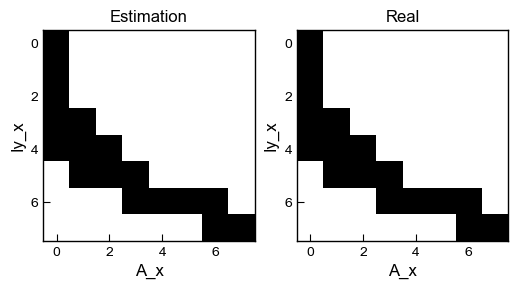

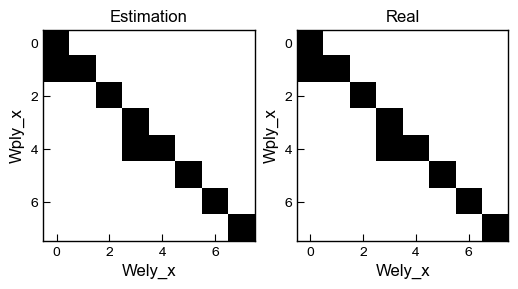

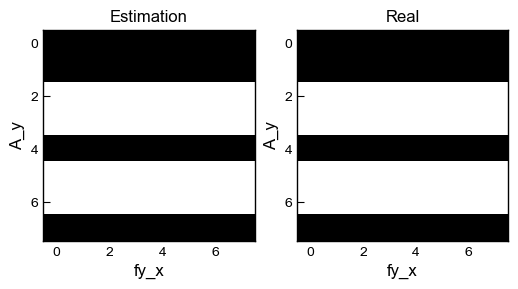

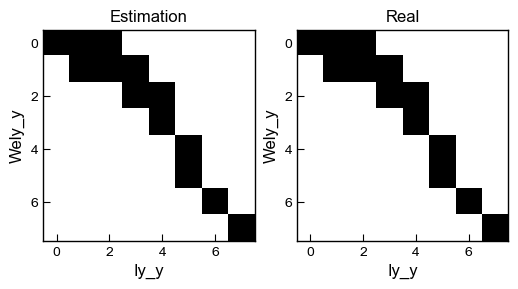

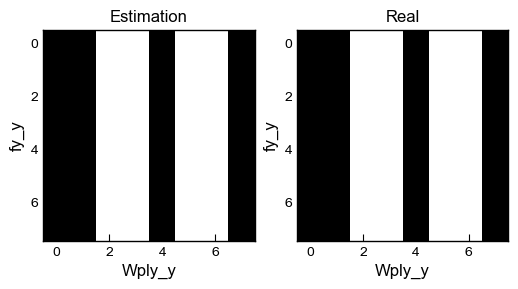

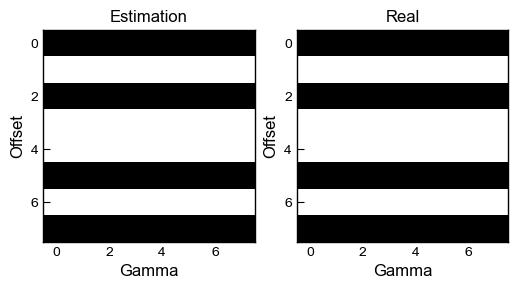

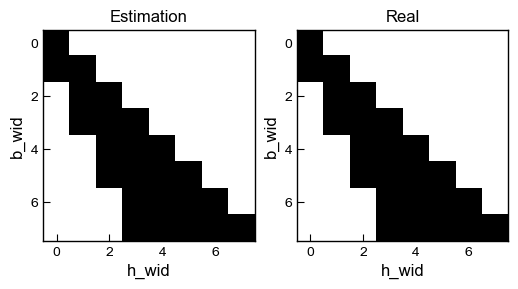

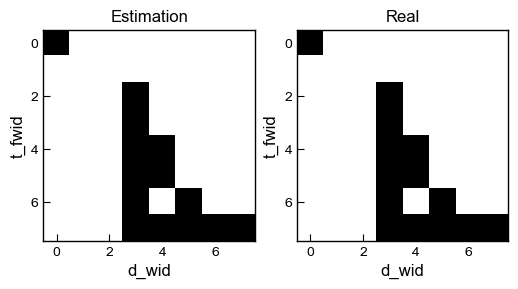

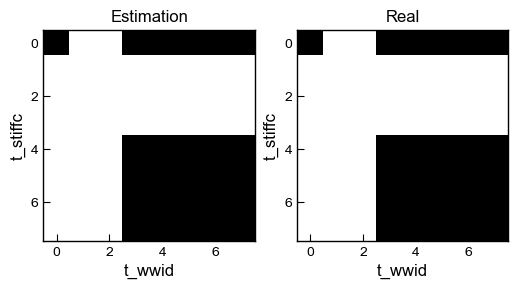

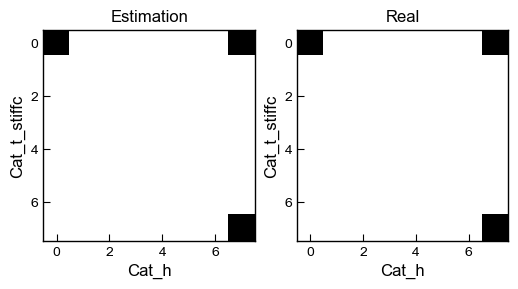

In [144]:
for i in range(len(features)//2):
    non_empty_2d = non_empty_hypercubes[:,2*i:2*i+2]
    non_empty_2d_unique = np.unique(non_empty_2d, axis=0)

    z = np.zeros((m,m))

    for x,y in non_empty_2d:
        z[x,y] += 1

    counts, _, _ = np.histogram2d(df_full[features[2*i]], df_full[features[2*i+1]], bins=m)

    fig, axs = plt.subplots(1,2, figsize=(6, 6))

    axs[0].imshow(z, cmap='Greys', interpolation='nearest', vmax=1)
    axs[1].imshow(counts, cmap='Greys', interpolation='nearest', vmax=1)

    axs[0].set_xlabel(features[2*i])
    axs[0].set_ylabel(features[2*i+1])
    axs[1].set_xlabel(features[2*i])
    axs[1].set_ylabel(features[2*i+1])

    axs[0].set_title('Estimation')
    axs[1].set_title('Real')

    plt.show()

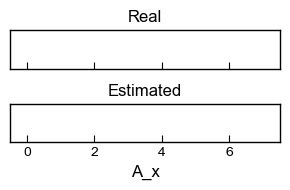

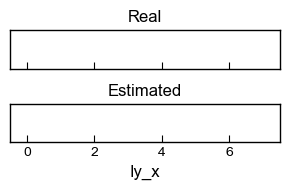

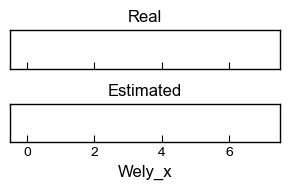

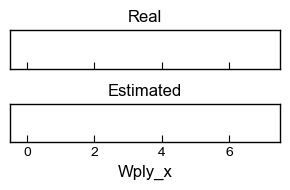

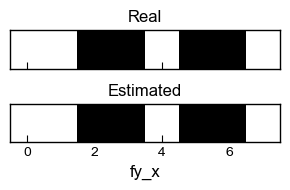

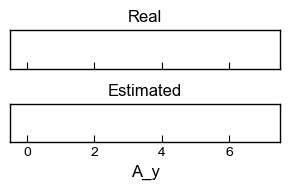

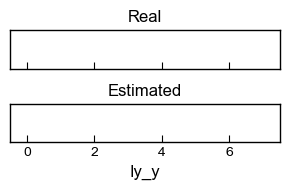

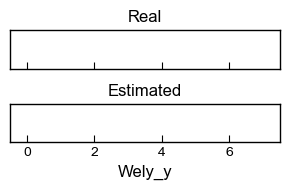

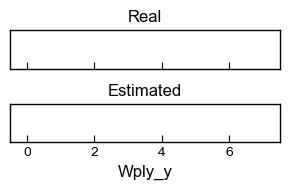

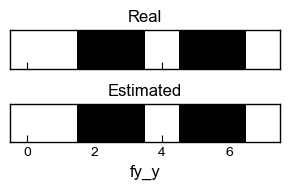

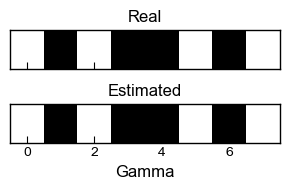

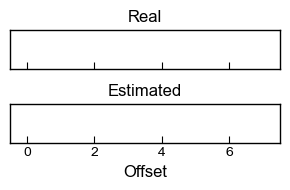

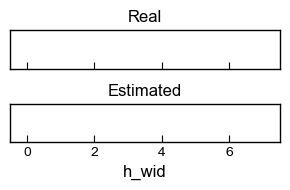

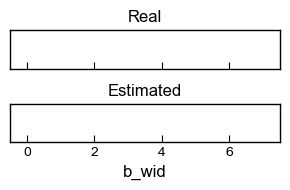

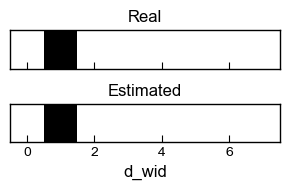

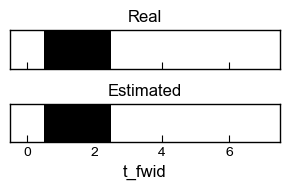

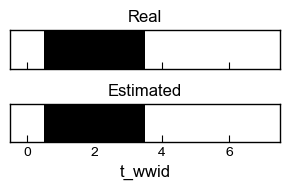

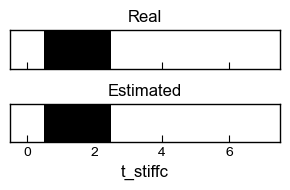

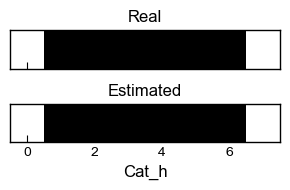

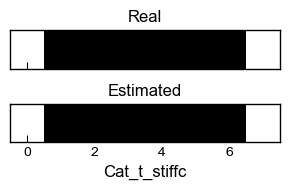

In [146]:
for i,feature in enumerate(features):
    non_empty_bins = non_empty_hypercubes[:,i]

    fig, axs = plt.subplots(2,1, figsize=(3, 2), sharex=True)

    z_real = df_full[feature].values
    counts_real, _ = np.histogram(z_real, bins=m)
    counts_real = np.clip(counts_real, 0, 1)
    axs[0].imshow(counts_real.reshape(-1,1).T, cmap='Greys', aspect='auto')
    axs[0].set_yticks([])

    counts_est, _ = np.histogram(non_empty_bins, bins=m)
    counts_est = np.clip(counts_est, 0, 1)
    axs[1].imshow(counts_est.reshape(-1,1).T, cmap='Greys', aspect='auto')
    axs[1].set_yticks([])

    axs[1].set_xlabel(feature)

    axs[0].set_title('Real')
    axs[1].set_title('Estimated')

    plt.tight_layout()
    plt.show()

### Method: Iterate Data instead of Hypercubes

In [6]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

In [7]:
df_full.columns

Index(['Profile_x', 'h_x', 'b_x', 'tw_x', 'tf_x', 'A_x', 'Av_x', 'Iy_x',
       'Wely_x', 'Wply_x', 'Steel grade_x', 'fy_x', 'tau_x', 'Vpl_x', 'Mpl_x',
       'Profile_y', 'h_y', 'b_y', 'tw_y', 'tf_y', 'A_y', 'Av_y', 'Iy_y',
       'Wely_y', 'Wply_y', 'Steel grade_y', 'fy_y', 'tau_y', 'Vpl_y', 'Mpl_y',
       'Gamma', 't_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid',
       't_stiffb', 'Offset', 'Offset_Idea', 'M', 'V', 'proz', 'M_Rd', 'V_Rd',
       'V_contribution', 'M_contribution', 'V_norm', 'M_norm', 'target',
       'Cat_h', 'Cat_t_stiffc', 'cost'],
      dtype='object')

In [17]:
features = ['h_x', 'b_x', 'tw_x', 'tf_x', 'A_x', 'Av_x', 'Iy_x',
       'Wely_x', 'Wply_x', 'fy_x', 'tau_x', 'Vpl_x', 'Mpl_x',
       'h_y', 'b_y', 'tw_y', 'tf_y', 'A_y', 'Av_y', 'Iy_y',
       'Wely_y', 'Wply_y', 'fy_y', 'tau_y', 'Vpl_y', 'Mpl_y',
       'Gamma', 't_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid',
       't_stiffb', 'Offset',
       'Cat_h', 'Cat_t_stiffc']

In [18]:
m = 8

In [19]:
bounds = np.array([[df_full[feature].min(), df_full[feature].max()] for feature in features])
hypercubemap = np.zeros((len(df_full), len(features)))

for i,data in enumerate(df_full[features].values):
    if i % 10000 == 0:
        print(f"Processing datapoint {i/len(df_full):.2%}")
    hypercubemap[i,:] = find_bins(data, bounds, m)


Processing datapoint 0.00%


C:\Users\benja\AppData\Local\Temp\ipykernel_4932\1220540224.py:6: RuntimeWarning: invalid value encountered in divide
  bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
C:\Users\benja\AppData\Local\Temp\ipykernel_4932\1220540224.py:6: RuntimeWarning: invalid value encountered in cast
  bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)


Processing datapoint 1.40%
Processing datapoint 2.80%
Processing datapoint 4.20%
Processing datapoint 5.60%
Processing datapoint 7.00%
Processing datapoint 8.40%
Processing datapoint 9.80%
Processing datapoint 11.20%
Processing datapoint 12.60%
Processing datapoint 14.00%
Processing datapoint 15.40%
Processing datapoint 16.80%
Processing datapoint 18.20%
Processing datapoint 19.60%
Processing datapoint 21.00%
Processing datapoint 22.40%
Processing datapoint 23.80%
Processing datapoint 25.20%
Processing datapoint 26.60%
Processing datapoint 28.00%
Processing datapoint 29.40%
Processing datapoint 30.80%
Processing datapoint 32.20%
Processing datapoint 33.60%
Processing datapoint 35.00%
Processing datapoint 36.39%
Processing datapoint 37.79%
Processing datapoint 39.19%
Processing datapoint 40.59%
Processing datapoint 41.99%
Processing datapoint 43.39%
Processing datapoint 44.79%
Processing datapoint 46.19%
Processing datapoint 47.59%
Processing datapoint 48.99%
Processing datapoint 50.39%

In [20]:
hypercubemap_unique, mapping = np.unique(hypercubemap, axis=0, return_inverse=True)

In [21]:
np.save(r"Saved Variables\hypercubemap.npy", hypercubemap_unique)
np.save(r"Saved Variables\hypercubemap_mapping.npy", mapping)

## Create Hypercubes from Domain Parameters (WIP)

Open Question: How would you define the inderdependencies between parameters in all the dimensions? 

To define all possible feasible combinations would surely be too much of an effort.

The hypercube distributions of the given data could be adapted, but for data with new parameters this cannot help.

In [ ]:
from itertools import product
import numpy as np

def generate_hypercube_structure(domains):
    """
    Generate all possible hypercube indices based on user-defined domains.

    Parameters:
    - domains: list of length D; each item is either:
        - A list of discrete values (defines bin centers)
        - A dict: {'range': (min, max), 'bins': m} (defines continuous bins)

    Returns:
    - all_bin_indices: list of all possible bin index tuples (e.g., (0, 1, 3, ...))
    - bin_edges_per_dim: list of bin edge arrays per dimension
    """
    bin_edges_per_dim = []

    for domain in domains:
        if isinstance(domain, dict):
            rmin, rmax = domain["range"]
            m = domain["bins"]
            edges = np.linspace(rmin, rmax, m + 1)
        elif isinstance(domain, list) or isinstance(domain, np.ndarray):
            edges = np.array(domain)
        else:
            raise ValueError("Each domain must be a list or a dict")
        bin_edges_per_dim.append(edges)

    num_bins_per_dim = [len(edges) - 1 for edges in bin_edges_per_dim]
    all_bin_indices = list(product(*[range(n) for n in num_bins_per_dim]))

    return all_bin_indices, bin_edges_per_dim

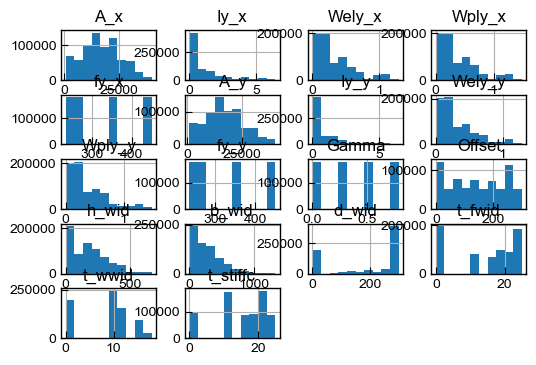

In [65]:
_ = df_full[features].hist()

In [67]:
domains = [{'range': (min(df_full['A_x']), max(df_full['A_x'])), 'bins': 5},
            {'range': (min(df_full['Iy_x']), max(df_full['Iy_x'])), 'bins': 5},
            {'range': (min(df_full['Wely_x']), max(df_full['Wely_x'])), 'bins': 5},
            {'range': (min(df_full['Wply_x']), max(df_full['Wply_x'])), 'bins': 5},
            {'range': (min(df_full['fy_x']), max(df_full['fy_x'])), 'bins': 5},
            {'range': (min(df_full['A_y']), max(df_full['A_y'])), 'bins': 5},
            {'range': (min(df_full['Iy_y']), max(df_full['Iy_y'])), 'bins': 5},
            {'range': (min(df_full['Wely_y']), max(df_full['Wely_y'])), 'bins': 5},
            {'range': (min(df_full['Wply_y']), max(df_full['Wply_y'])), 'bins': 5},
            {'range': (min(df_full['fy_y']), max(df_full['fy_y'])), 'bins': 5},
            {'range': (min(df_full['Gamma']), max(df_full['Gamma'])), 'bins': 5},
            {'range': (min(df_full['Offset']), max(df_full['Offset'])), 'bins': 5},
            {'range': (min(df_full['h_wid']), max(df_full['h_wid'])), 'bins': 5},
            {'range': (min(df_full['b_wid']), max(df_full['b_wid'])), 'bins': 5},
            {'range': (min(df_full['d_wid']), max(df_full['d_wid'])), 'bins': 5},
            {'range': (min(df_full['t_fwid']), max(df_full['t_fwid'])), 'bins': 5},
            {'range': (min(df_full['t_wwid']), max(df_full['t_wwid'])), 'bins': 5},
            {'range': (min(df_full['t_stiffc']), max(df_full['t_stiffc'])), 'bins': 5}
           ]

### Based on given Data

In [7]:
from Helper_Functions import analyze_hypercube_density

In [8]:
features

['A_x',
 'Iy_x',
 'Wely_x',
 'Wply_x',
 'fy_x',
 'A_y',
 'Iy_y',
 'Wely_y',
 'Wply_y',
 'fy_y',
 'Gamma',
 'Offset',
 'h_wid',
 'b_wid',
 'd_wid',
 't_fwid',
 't_wwid',
 't_stiffc']

In [9]:
m = 5

In [10]:
data = df_full[features].values
results = analyze_hypercube_density(data, num_bins=m)

Analyzing hypercube density with 714,385 points
Number of occupied hypercubes: 32,810 out of 3,814,697,265,625
Occupancy rate: 0.00000086%
Average points per occupied hypercube: 21.77
Maximum points in any hypercube: 789
Estimated empty hypercubes: 3,814,697,232,815
Estimated empty percentage: 99.9999991399%


In [11]:
non_empty_hypercubes = list(results['hypercubes'].keys())
non_empty_hypercubes = np.array(non_empty_hypercubes)

In [12]:
hypercube_indices = results['hypercube_indices']
hypercube_unique = np.unique(hypercube_indices, axis=0)

In [13]:
from collections import defaultdict

hypercube_map = defaultdict(list)

for idx, cube in enumerate(map(tuple, hypercube_indices)):
    hypercube_map[cube].append(idx)

hypercube_contents = [np.array(hypercube_map[tuple(cube)]) for cube in hypercube_unique]

In [35]:
upper_bound = np.max(df_full[features].values, axis=0)
lower_bound = np.min(df_full[features].values, axis=0)

edges = np.array([np.linspace(lower_bound[i], upper_bound[i], m+1) for i in range(len(features))])

Draws a random sample (uniform) from a given hypercube. The drawn sample should be somewhat feasible, since it will represent the data distribution in the hypercube space.

In [34]:
def draw_sample_from_hypercube(hypercube):
    hypercube_index = np.where(np.all(hypercube_unique == hypercube, axis=1))[0][0]
    hypercube_coordinates = hypercube_unique[hypercube_index]
    lower_hypercube_bound = np.array([edges[i,index] for i,index in enumerate(hypercube_coordinates)])
    upper_hypercube_bound = np.array([edges[i,index+1] for i,index in enumerate(hypercube_coordinates)])
    random_sample = np.random.uniform(lower_hypercube_bound, upper_hypercube_bound)
    return random_sample

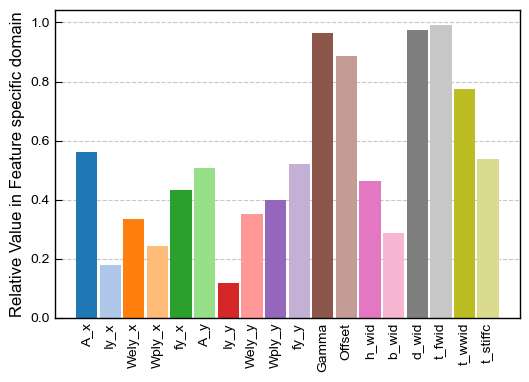

In [16]:
drawn_sample = draw_sample_from_hypercube(non_empty_hypercubes[np.random.randint(0, len(non_empty_hypercubes))])

fig, ax = plt.subplots(figsize=(6, 4))

drawn_sample_norm = (drawn_sample - lower_bound) / (upper_bound - lower_bound)
plt.bar(np.arange(len(drawn_sample)),
        drawn_sample_norm, width=0.9,
        zorder=2,
        color=plot_params.morecolors[:len(features)])

plt.ylabel('Relative Value in Feature specific domain')

plt.xticks(np.arange(len(drawn_sample)), features, rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.show()

In [17]:
samples = np.array([draw_sample_from_hypercube(non_empty_hypercubes[np.random.randint(0, len(non_empty_hypercubes))]) for _ in range(1000)])

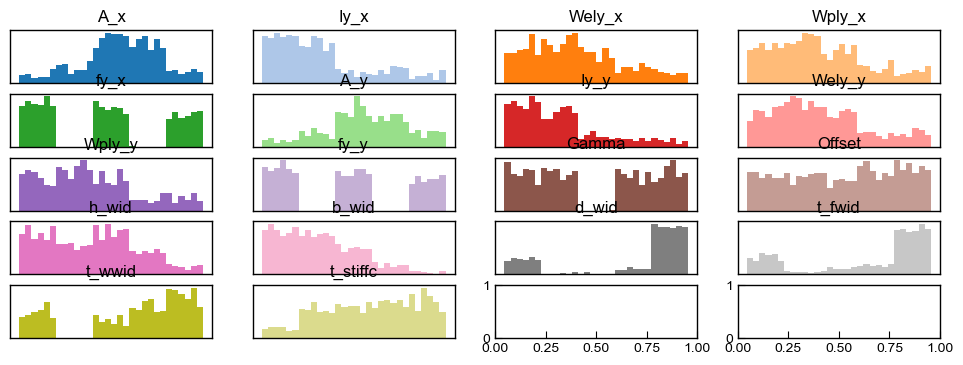

In [23]:
fig, axs = plt.subplots(int(len(features)/4+1),4,figsize=(12,4))

for i, feature in enumerate(features):
    ax = axs[i//4, i%4]
    ax.hist(samples[:,i], bins=30, color=plot_params.morecolors[i])
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

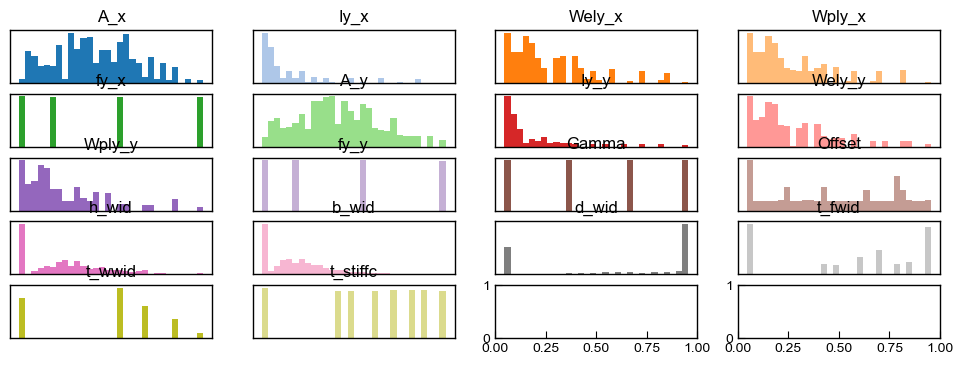

In [22]:
fig, axs = plt.subplots(int(len(features)/4+1),4,figsize=(12,4))

for i, feature in enumerate(features):
    ax = axs[i//4, i%4]
    ax.hist(data[:,i], bins=30, color=plot_params.morecolors[i])
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Make the sampling more accurate by introducing discrete values for certain features instead of ranges. The sampling over a bin could also be made more accurate by learning the distribution of the data in a given feature and bin and then sampling from that distribution.

In [25]:
discrete_domains = {'fy_x': np.unique(df_full['fy_x'].values),
                    'fy_y': np.unique(df_full['fy_y'].values),
                    'Gamma': np.unique(df_full['Gamma'].values),
                    't_stiffc': np.unique(df_full['t_stiffc'].values),
                    't_fwid': np.unique(df_full['t_fwid'].values),
                    't_wwid': np.unique(df_full['t_wwid'].values),}

In [33]:
edges[4]

array([235., 278., 321., 364., 407., 450.])

In [26]:
discrete_domains['fy_x']

array([235, 275, 355, 450], dtype=int64)